## Testing modified method and normal method
- Using random unitaries for the checking of the models
- Again, the unitary group class is used for random sampling

In [2]:
from qiskit import QuantumCircuit, execute, transpile, Aer 
from qiskit.extensions import UnitaryGate,Initialize
from qiskit.quantum_info import Statevector 
from qiskit.tools.visualization import plot_bloch_vector
from qiskit.tools.visualization import plot_histogram,plot_bloch_multivector  
import numpy as np 
from time import sleep 
import sys 
from scipy.stats import unitary_group 
import matplotlib.pyplot as plt 
%matplotlib inline 

In [3]:
from normal_SPEA import SPEA 
from changed_SPEA import global_max_SPEA 

- Defining Function to test the algorithms

In [17]:
def generate_random_estimation(unitaries,SPE_type,resolution = 40,save = True):
    
    best_costs, errors_in_phases = [] , [] 
    for i,u_rand in enumerate(unitaries):
        print("FOR UNITARY ",i+1)
        # generate the phases and vectors 
        eigen_phases, eigen_vectors = np.linalg.eig(u_rand)
        eigen_phases = np.angle(eigen_phases)
        ep = []
        
        # doing this as phase maybe be negative 
        for k in eigen_phases:
            if k < 0:
                ep.append(k + 2*np.pi)
            else:
                ep.append(k)
        eigen_phases = ep
        
        ev1 , ev2 = eigen_vectors[0] , eigen_vectors[1]
        ev1 = ev1 / np.linalg.norm(ev1)
        ev2 = ev2 / np.linalg.norm(ev2)
        
        # generate their corresponding init statevectors 
        sv1 = Initialize(ev1)
        sv2 = Initialize(ev2)
        print("Eigenvectors",ev1,ev2)
        print("Eigenphases",eigen_phases)
        
        
        # run the algorithm 
        if SPE_type == 'original':
            spea = SPEA(resolution = resolution, max_iters = 10, unitary = u_rand,error = 4)
        else:
            spea = global_max_SPEA(resolution = resolution, max_iters = 10, unitary = u_rand,error = 4)
        result = spea.get_eigen_pair(progress = False, randomize = True)
        # get the results 
        res_state = result['state']
        res_theta = 2*np.pi*result['theta']
        sv_res = Initialize(res_state)
        print("Result",result)
        print("Phase returned(0-> 2*pi) :",res_theta)
        # get the dot products 
        d1 = np.linalg.norm(np.dot(ev1, res_state.conjugate().T))**2 
        d2 = np.linalg.norm(np.dot(ev2, res_state.conjugate().T))**2 
    
        # make a bloch sphere
        qc = QuantumCircuit(2)
        qc = qc.compose(sv_res,qubits = [0])
        if d1 > d2:
            print("Best overlap :",d1)
            # it is closer to the first
            qc = qc.compose(sv1,qubits = [1])
            best_costs.append(result['cost'])
            errors_in_phases.append(abs(res_theta - eigen_phases[0]))
        else:
            # it is closer to the second
            print("Best overlap :",d2)
            qc = qc.compose(sv2,qubits = [1])
            best_costs.append(result['cost'])
            errors_in_phases.append(abs(res_theta - eigen_phases[1]))
        print("Bloch Sphere for the states...")
        s = Statevector.from_instruction(qc)
        display(plot_bloch_multivector(s))
        
    if SPE_type == 'original':
        plt.title("Experiments over Random Matrices for original SPEA",fontsize= 16)
    else:
        plt.title("Experiments over Random Matrices for modified SPEA",fontsize= 16)
    
    plt.xlabel("Experiment Number")
    plt.ylabel("Metric value")
    plt.plot([i for i in range(len(unitaries))], best_costs, label = 'Best Costs', alpha = 0.5, color = 'r',marker='o',linewidth = 2)
    plt.plot([i for i in range(len(unitaries))], errors_in_phases, label = 'Corresponding Error in Phase',linewidth = 2, alpha = 0.5, color = 'b',marker='s') 
    plt.legend()
    plt.grid()
    if save:
        if SPE_type == 'original':
            plt.savefig("Random Estimation for Original SPE.jpg",dpi = 200)
        else:
            plt.savefig("Random Estimation for Modified SPE.jpg",dpi = 200)



### Defining matrices

In [18]:
unitaries = []
for i in range(6):
    u = unitary_group.rvs(2)
    unitaries.append(u)
print("Unitaries :",unitaries) 

Unitaries : [array([[ 0.00660452+0.25405997j,  0.83594171+0.48642715j],
       [ 0.83706266-0.48449563j, -0.00719114+0.25404405j]]), array([[-0.77199138+0.25645228j,  0.18476497+0.55147388j],
       [-0.5670876 -0.12912471j,  0.17857401-0.79363077j]]), array([[ 0.11269687-0.03919376j,  0.97649242+0.17951552j],
       [ 0.97289755-0.1980748j , -0.11342267-0.03704098j]]), array([[ 0.30752816+0.59270861j,  0.07643808+0.74045942j],
       [-0.74047868+0.07625133j,  0.64298709+0.18012402j]]), array([[ 0.2956312 +0.11627227j, -0.82620207+0.46526669j],
       [ 0.73835283-0.59491012j,  0.00158204-0.3176705j ]]), array([[-0.56778971+0.43203402j,  0.48365083-0.50699441j],
       [-0.51813789+0.47169331j, -0.44516049+0.55755779j]])]


## Testing for the First Algorithm 

FOR UNITARY  1
Eigenvectors [ 0.70962378+0.j         -0.60939261-0.35365907j] [0.60939261-0.35365907j 0.70962378+0.j        ]
Eigenphases [0.25802212275387487, 2.885879570053374]
Maximum iterations reached for the estimation.
Terminating algorithm...
Result {'cost': 0.990234375, 'theta': 0.4502551020408162, 'state': array([-0.01974449+0.76286638j, -0.47526388-0.43791469j])}
Phase returned(0-> 2*pi) : 2.8290362416255017
Best overlap : 0.5950809479329764
Bloch Sphere for the states...


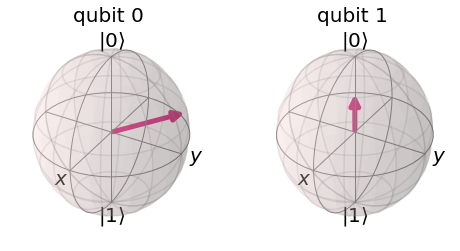

FOR UNITARY  2
Eigenvectors [ 0.94148876+0.j         -0.16507116+0.29385443j] [0.16507116+0.29385443j 0.94148876+0.j        ]
Eigenphases [2.7182498966853563, 5.0363282699235254]
Maximum iterations reached for the estimation.
Terminating algorithm...
Result {'cost': 0.98046875, 'theta': 0.446109693877551, 'state': array([-0.19405516+0.85720344j, -0.34284857+0.33166206j])}
Phase returned(0-> 2*pi) : 2.8029898739618115
Best overlap : 0.7285100056004
Bloch Sphere for the states...


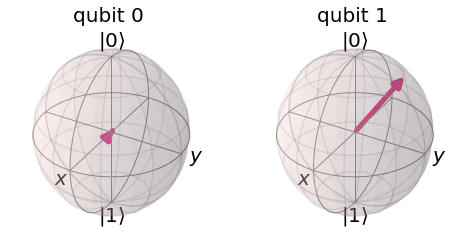

FOR UNITARY  3
Eigenvectors [ 0.74603858+0.j         -0.65375179-0.12662953j] [0.65375179-0.12662953j 0.74603858+0.j        ]
Eigenphases [6.235536700057658, 3.1702007212873964]
Maximum iterations reached for the estimation.
Terminating algorithm...
Result {'cost': 0.962890625, 'theta': 0.01883475953896761, 'state': array([-0.6046944 +0.35132519j, -0.70190139+0.13509156j])}
Phase returned(0-> 2*pi) : 0.11834228439950184
Best overlap : 0.9927035918312787
Bloch Sphere for the states...


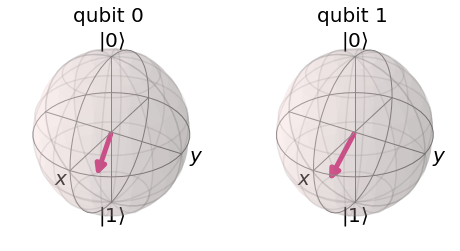

FOR UNITARY  4
Eigenvectors [ 0.81742249+0.j         -0.40726944+0.40737216j] [0.40726944+0.40737216j 0.81742249+0.j        ]
Eigenphases [1.594202802745888, 6.05429855555342]
Maximum iterations reached for the estimation.
Terminating algorithm...
Result {'cost': 0.923828125, 'theta': 0.21314035818408997, 'state': array([-0.19965831-0.85180325j, -0.20686851-0.43791916j])}
Phase returned(0-> 2*pi) : 1.3392003669092685
Best overlap : 0.7457103226763044
Bloch Sphere for the states...


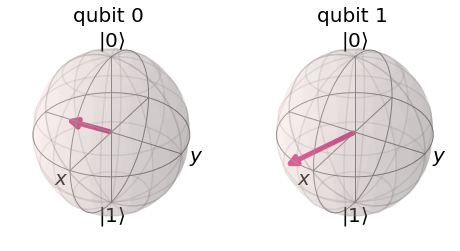

FOR UNITARY  5
Eigenvectors [0.79574521+0.j         0.05001293-0.60356297j] [-0.05001293-0.60356297j  0.79574521+0.j        ]
Eigenphases [0.7947581024569101, 4.297329687162742]
Maximum iterations reached for the estimation.
Terminating algorithm...
Result {'cost': 0.89453125, 'theta': 0.9980132887007341, 'state': array([-0.3891819 +0.67977031j,  0.55380673+0.28239669j])}
Phase returned(0-> 2*pi) : 6.270702431934431
Best overlap : 0.9955614526982025
Bloch Sphere for the states...


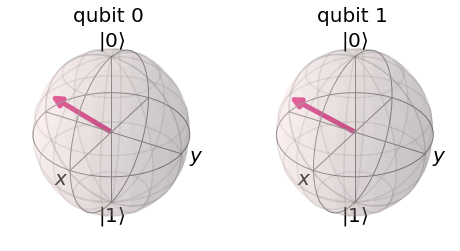

FOR UNITARY  6
Eigenvectors [ 0.74975048+0.j        -0.02330329-0.6613102j] [0.02330329-0.6613102j 0.74975048+0.j       ]
Eigenphases [3.1519164767536862, 1.5838001819585021]
Maximum iterations reached for the estimation.
Terminating algorithm...
Result {'cost': 0.89453125, 'theta': 0.4081632653061224, 'state': array([-0.73652892-0.61235913j,  0.20017046+0.20609032j])}
Phase returned(0-> 2*pi) : 2.5645654315018716
Best overlap : 0.5904023950640273
Bloch Sphere for the states...


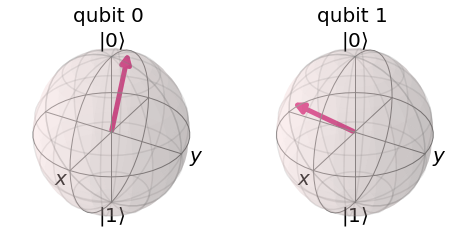

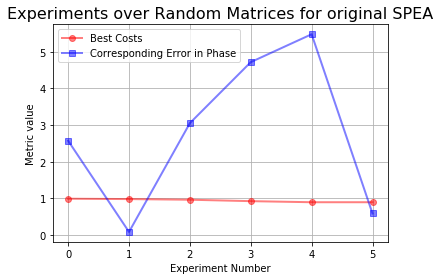

In [19]:
generate_random_estimation(unitaries,'original',resolution=50)

## Testing for the Modified Algorithm

FOR UNITARY  1
Eigenvectors [ 0.70962378+0.j         -0.60939261-0.35365907j] [0.60939261-0.35365907j 0.70962378+0.j        ]
Eigenphases [0.25802212275387487, 2.885879570053374]
Maximum iterations reached for the estimation.
Terminating algorithm...
Result {'cost': 0.974609375, 'theta': 0.033207235004729566, 'state': array([-0.03562247+0.81782703j,  0.42560294+0.38568398j])}
Phase returned(0-> 2*pi) : 0.20864721107377646
Best overlap : 0.5768743733401095
Bloch Sphere for the states...


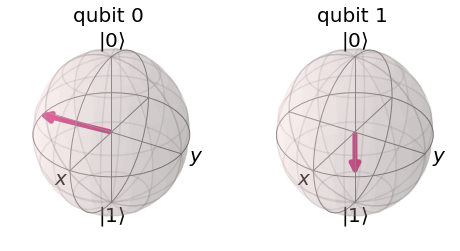

FOR UNITARY  2
Eigenvectors [ 0.94148876+0.j         -0.16507116+0.29385443j] [0.16507116+0.29385443j 0.94148876+0.j        ]
Eigenphases [2.7182498966853563, 5.0363282699235254]
Maximum iterations reached for the estimation.
Terminating algorithm...
Result {'cost': 0.986328125, 'theta': 0.7919323979591835, 'state': array([ 0.11568146+0.13505801j, -0.24234235-0.95375433j])}
Phase returned(0-> 2*pi) : 4.9758580071366385
Best overlap : 0.8561494746137239
Bloch Sphere for the states...


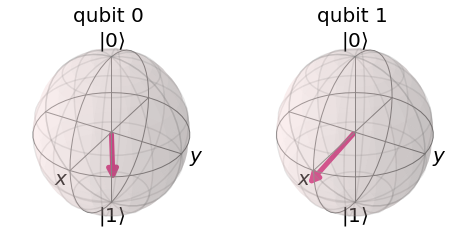

FOR UNITARY  3
Eigenvectors [ 0.74603858+0.j         -0.65375179-0.12662953j] [0.65375179-0.12662953j 0.74603858+0.j        ]
Eigenphases [6.235536700057658, 3.1702007212873964]
Maximum iterations reached for the estimation.
Terminating algorithm...
Result {'cost': 0.990234375, 'theta': 0.5177774234693878, 'state': array([ 0.42327781-0.35916876j, -0.64929741+0.51985245j])}
Phase returned(0-> 2*pi) : 3.25329149953216
Best overlap : 0.9309981104396249
Bloch Sphere for the states...


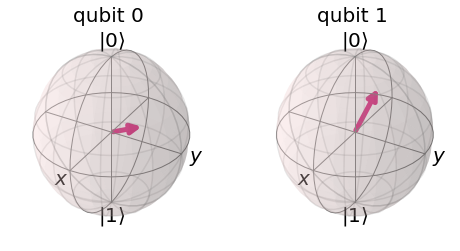

FOR UNITARY  4
Eigenvectors [ 0.81742249+0.j         -0.40726944+0.40737216j] [0.40726944+0.40737216j 0.81742249+0.j        ]
Eigenphases [1.594202802745888, 6.05429855555342]
Maximum iterations reached for the estimation.
Terminating algorithm...
Result {'cost': 0.962890625, 'theta': 0.004452731217434912, 'state': array([-0.37233007-0.02670975j,  0.90003599+0.22492694j])}
Phase returned(0-> 2*pi) : 0.02797733536220691
Best overlap : 0.566049418658021
Bloch Sphere for the states...


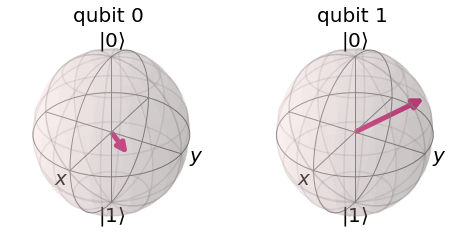

FOR UNITARY  5
Eigenvectors [0.79574521+0.j         0.05001293-0.60356297j] [-0.05001293-0.60356297j  0.79574521+0.j        ]
Eigenphases [0.7947581024569101, 4.297329687162742]
Maximum iterations reached for the estimation.
Terminating algorithm...
Result {'cost': 0.990234375, 'theta': 0.6912972459391921, 'state': array([-0.07723418-0.45731705j,  0.86749105-0.17987575j])}
Phase returned(0-> 2*pi) : 4.343548698578845
Best overlap : 0.969106030258105
Bloch Sphere for the states...


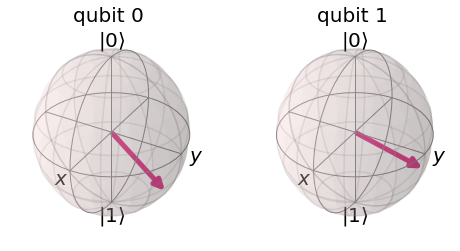

FOR UNITARY  6
Eigenvectors [ 0.74975048+0.j        -0.02330329-0.6613102j] [0.02330329-0.6613102j 0.74975048+0.j       ]
Eigenphases [3.1519164767536862, 1.5838001819585021]
Maximum iterations reached for the estimation.
Terminating algorithm...
Result {'cost': 0.9609375, 'theta': 0.2745535714285713, 'state': array([ 0.5490777 -0.33577869j, -0.25438745+0.72184027j])}
Phase returned(0-> 2*pi) : 1.72507096603368
Best overlap : 0.8056339409537772
Bloch Sphere for the states...


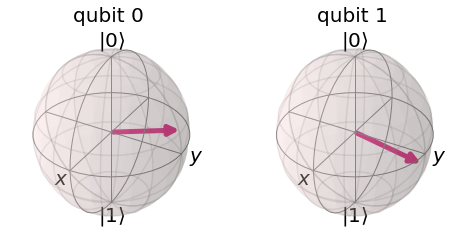

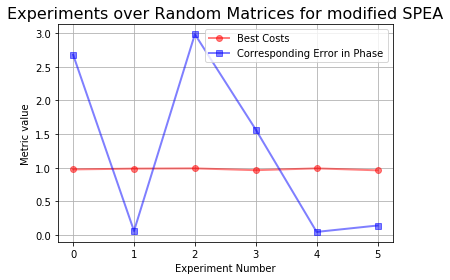

In [20]:
generate_random_estimation(unitaries,'modified',resolution=50)